In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import widgets
from projection import Quaternion, project_points

In [2]:
class Cube:
    """Magic Cube Representation"""
    # define some attribues
    default_plastic_color = 'black'
    default_face_colors = ["w", "#ffcf00",
                           "#00008f", "#009f0f",
                           "#ff6f00", "#cf0000",
                           "gray", "none"]
    base_face = np.array([[1, 1, 1],
                          [1, -1, 1],
                          [-1, -1, 1],
                          [-1, 1, 1],
                          [1, 1, 1]], dtype=float)
    stickerwidth = 0.9
    stickermargin = 0.5 * (1. - stickerwidth)
    stickerthickness = 0.001
    (d1, d2, d3) = (1 - stickermargin,
                    1 - 2 * stickermargin,
                    1 + stickerthickness)
    base_sticker = np.array([[d1, d2, d3], [d2, d1, d3],
                             [-d2, d1, d3], [-d1, d2, d3],
                             [-d1, -d2, d3], [-d2, -d1, d3],
                             [d2, -d1, d3], [d1, -d2, d3],
                             [d1, d2, d3]], dtype=float)

    base_face_centroid = np.array([[0, 0, 1]])
    base_sticker_centroid = np.array([[0, 0, 1 + stickerthickness]])

    # Define rotation angles and axes for the six sides of the cube
    x, y, z = np.eye(3)
    rots = [Quaternion.from_v_theta(np.eye(3)[0], theta)
    for theta in (np.pi / 2, -np.pi / 2)]
    rots += [Quaternion.from_v_theta(np.eye(3)[1], theta)
    for theta in (np.pi / 2, -np.pi / 2, np.pi, 2 * np.pi)]

    # define face movements
    facesdict = dict(F=z, B=-z,
                     R=x, L=-x,
                     U=y, D=-y)

    def __init__(self, N=3, plastic_color=None, face_colors=None):
        self.N = N
        if plastic_color is None:
            self.plastic_color = self.default_plastic_color
        else:
            self.plastic_color = plastic_color

        if face_colors is None:
            self.face_colors = self.default_face_colors
        else:
            self.face_colors = face_colors

        self._move_list = []
        self._initialize_arrays()

    def _initialize_arrays(self):
        # initialize centroids, faces, and stickers.  We start with a
        # base for each one, and then translate & rotate them into position.

        # Define N^2 translations for each face of the cube
        cubie_width = 2. / self.N
        translations = np.array([[[-1 + (i + 0.5) * cubie_width,
                                   -1 + (j + 0.5) * cubie_width, 0]]
                                 for i in range(self.N)
                                 for j in range(self.N)])

        # Create arrays for centroids, faces, stickers, and colors
        face_centroids = []
        faces = []
        sticker_centroids = []
        stickers = []
        colors = []

        factor = np.array([1. / self.N, 1. / self.N, 1])

        for i in range(6):
            M = self.rots[i].as_rotation_matrix()
            faces_t = np.dot(factor * self.base_face
                             + translations, M.T)
            stickers_t = np.dot(factor * self.base_sticker
                                + translations, M.T)
            face_centroids_t = np.dot(self.base_face_centroid
                                      + translations, M.T)
            sticker_centroids_t = np.dot(self.base_sticker_centroid
                                         + translations, M.T)
            colors_i = i + np.zeros(face_centroids_t.shape[0], dtype=int)

            # append face ID to the face centroids for lex-sorting
            face_centroids_t = np.hstack([face_centroids_t.reshape(-1, 3),
                                          colors_i[:, None]])
            sticker_centroids_t = sticker_centroids_t.reshape((-1, 3))

            faces.append(faces_t)
            face_centroids.append(face_centroids_t)
            stickers.append(stickers_t)
            sticker_centroids.append(sticker_centroids_t)
            colors.append(colors_i)

        self._face_centroids = np.vstack(face_centroids)
        self._faces = np.vstack(faces)
        self._sticker_centroids = np.vstack(sticker_centroids)
        self._stickers = np.vstack(stickers)
        self._colors = np.concatenate(colors)

        self._sort_faces()

    def _sort_faces(self):
        # use lexsort on the centroids to put faces in a standard order.
        ind = np.lexsort(self._face_centroids.T)
        self._face_centroids = self._face_centroids[ind]
        self._sticker_centroids = self._sticker_centroids[ind]
        self._stickers = self._stickers[ind]
        self._colors = self._colors[ind]
        self._faces = self._faces[ind]

    def rotate_face(self, f, n=1, layer=0):
        """Rotate Face"""
        if layer < 0 or layer >= self.N:
            raise ValueError('layer should be between 0 and N-1')

        try:
            f_last, n_last, layer_last = self._move_list[-1]
        except:
            f_last, n_last, layer_last = None, None, None

        if (f == f_last) and (layer == layer_last):
            ntot = (n_last + n) % 4
            if abs(ntot - 4) < abs(ntot):
                ntot = ntot - 4
            if np.allclose(ntot, 0):
                self._move_list = self._move_list[:-1]
            else:
                self._move_list[-1] = (f, ntot, layer)
        else:
            self._move_list.append((f, n, layer))
        
        v = self.facesdict[f]
        r = Quaternion.from_v_theta(v, n * np.pi / 2)
        M = r.as_rotation_matrix()

        proj = np.dot(self._face_centroids[:, :3], v)
        cubie_width = 2. / self.N
        flag = ((proj > 0.9 - (layer + 1) * cubie_width) &
                (proj < 1.1 - layer * cubie_width))

        for x in [self._stickers, self._sticker_centroids,
                  self._faces]:
            x[flag] = np.dot(x[flag], M.T)
        self._face_centroids[flag, :3] = np.dot(self._face_centroids[flag, :3],
                                                M.T)

    def draw_interactive(self,v):
        fig = plt.figure(figsize=(5, 5))
        fig.add_axes(InteractiveCube(self,view =v))
        return fig
    



In [3]:
class InteractiveCube(plt.Axes):
    def __init__(self, cube=None,
                 interactive=True,
        # This Changes the view of the cube when plotting the cube
                 view=(0, -10, 10),
                 fig=None, rect=[0, 0.16, 1, 0.84],
                 **kwargs):
        if cube is None:
            self.cube = Cube(3)
        elif isinstance(cube, Cube):
            self.cube = cube
        else:
            self.cube = Cube(cube)

        self._view = view
        self._start_rot = Quaternion.from_v_theta((1, -1, 0),
                                                  -np.pi / 6)

        if fig is None:
            fig = plt.gcf()

        # disable default key press events
        callbacks = fig.canvas.callbacks.callbacks
        del callbacks['key_press_event']

        # add some defaults, and draw axes
        kwargs.update(dict(aspect=kwargs.get('aspect', 'equal'),
                           xlim=kwargs.get('xlim', (-2.0, 2.0)),
                           ylim=kwargs.get('ylim', (-2.0, 2.0)),
                           frameon=kwargs.get('frameon', False),
                           xticks=kwargs.get('xticks', []),
                           yticks=kwargs.get('yticks', [])))
        super(InteractiveCube, self).__init__(fig, rect, **kwargs)
        self.xaxis.set_major_formatter(plt.NullFormatter())
        self.yaxis.set_major_formatter(plt.NullFormatter())

        self._start_xlim = kwargs['xlim']
        self._start_ylim = kwargs['ylim']

        # Define movement for up/down arrows or up/down mouse movement
        self._ax_UD = (1, 0, 0)
        self._step_UD = 0.01

        # Define movement for left/right arrows or left/right mouse movement
        self._ax_LR = (0, -1, 0)
        self._step_LR = 0.01

        self._ax_LR_alt = (0, 0, 1)

        # Internal state variable
        self._active = False  # true when mouse is over axes
        self._button1 = False  # true when button 1 is pressed
        self._button2 = False  # true when button 2 is pressed
        self._event_xy = None  # store xy position of mouse event
        self._shift = False  # shift key pressed
        self._digit_flags = np.zeros(10, dtype=bool)  # digits 0-9 pressed

        self._current_rot = self._start_rot  #current rotation state
        self._face_polys = None
        self._sticker_polys = None

        self._draw_cube()

        # connect some GUI events
        #self.figure.canvas.mpl_connect('button_press_event',
        #                               self._mouse_press)
        #self.figure.canvas.mpl_connect('button_release_event',
        #                               self._mouse_release)
        #self.figure.canvas.mpl_connect('motion_notify_event',
        #                               self._mouse_motion)
        #self.figure.canvas.mpl_connect('key_press_event',
        #                               self._key_press)
        #self.figure.canvas.mpl_connect('key_release_event',
        #                               self._key_release)

        #self._initialize_widgets()

        # write some instructions
        #self.figure.text(0.05, 0.05,
        #                 "Mouse/arrow keys adjust view\n"
        #                 "U/D/L/R/B/F keys turn faces\n"
        #                 "(hold shift for counter-clockwise)",
        #                 size=10)

    def _initialize_widgets(self):
        stupid = 0
        #self._ax_reset = self.figure.add_axes([0.75, 0.05, 0.2, 0.075])
        #self._btn_reset = widgets.Button(self._ax_reset, 'Reset View')
        #self._btn_reset.on_clicked(self._reset_view)

        #self._ax_solve = self.figure.add_axes([0.55, 0.05, 0.2, 0.075])
        #self._btn_solve = widgets.Button(self._ax_solve, 'Solve Cube')
        #self._btn_solve.on_clicked(self._solve_cube)
        
    def change_view(self):
        view = (0,10,10)

    def _project(self, pts):
        return project_points(pts, self._current_rot, self._view, [0, 1, 0])

    def _draw_cube(self):
        stickers = self._project(self.cube._stickers)[:, :, :2]
        faces = self._project(self.cube._faces)[:, :, :2]
        face_centroids = self._project(self.cube._face_centroids[:, :3])
        sticker_centroids = self._project(self.cube._sticker_centroids[:, :3])

        plastic_color = self.cube.plastic_color
        colors = np.asarray(self.cube.face_colors)[self.cube._colors]
        face_zorders = -face_centroids[:, 2]
        sticker_zorders = -sticker_centroids[:, 2]

        if self._face_polys is None:
            # initial call: create polygon objects and add to axes
            self._face_polys = []
            self._sticker_polys = []

            for i in range(len(colors)):
                fp = plt.Polygon(faces[i], facecolor=plastic_color,
                                 zorder=face_zorders[i])
                sp = plt.Polygon(stickers[i], facecolor=colors[i],
                                 zorder=sticker_zorders[i])

                self._face_polys.append(fp)
                self._sticker_polys.append(sp)
                self.add_patch(fp)
                self.add_patch(sp)
        else:
            # subsequent call: update the polygon objects
            for i in range(len(colors)):
                self._face_polys[i].set_xy(faces[i])
                self._face_polys[i].set_zorder(face_zorders[i])
                self._face_polys[i].set_facecolor(plastic_color)

                self._sticker_polys[i].set_xy(stickers[i])
                self._sticker_polys[i].set_zorder(sticker_zorders[i])
                self._sticker_polys[i].set_facecolor(colors[i])

        self.figure.canvas.draw()

    def rotate(self, rot):
        self._current_rot = self._current_rot * rot

    def rotate_face(self, face, turns=1, layer=0, steps=5):
        if not np.allclose(turns, 0):
            for i in range(steps):
                self.cube.rotate_face(face, turns * 1. / steps,
                                      layer=layer)
                self._draw_cube()

    def _reset_view(self, *args):
        self.set_xlim(self._start_xlim)
        self.set_ylim(self._start_ylim)
        self._current_rot = self._start_rot
        self._draw_cube()

    def _solve_cube(self, *args):
        move_list = self.cube._move_list[:]
        for (face, n, layer) in move_list[::-1]:
            self.rotate_face(face, -n, layer, steps=3)
        self.cube._move_list = []

    def _key_press(self, event):
        """Handler for key press events"""
        if event.key == 'shift':
            self._shift = True
        elif event.key.isdigit():
            self._digit_flags[int(event.key)] = 1
        elif event.key == 'right':
            if self._shift:
                ax_LR = self._ax_LR_alt
            else:
                ax_LR = self._ax_LR
            self.rotate(Quaternion.from_v_theta(ax_LR,
                                                5 * self._step_LR))
        elif event.key == 'left':
            if self._shift:
                ax_LR = self._ax_LR_alt
            else:
                ax_LR = self._ax_LR
            self.rotate(Quaternion.from_v_theta(ax_LR,
                                                -5 * self._step_LR))
        elif event.key == 'up':
            self.rotate(Quaternion.from_v_theta(self._ax_UD,
                                                5 * self._step_UD))
        elif event.key == 'down':
            self.rotate(Quaternion.from_v_theta(self._ax_UD,
                                                -5 * self._step_UD))
        elif event.key.upper() in 'LRUDBF':
            if self._shift:
                direction = -1
            else:
                direction = 1

            if np.any(self._digit_flags[:N]):
                for d in np.arange(N)[self._digit_flags[:N]]:
                    self.rotate_face(event.key.upper(), direction, layer=d)
            else:
                self.rotate_face(event.key.upper(), direction)
                
        self._draw_cube()

    
   

    

    

In [8]:
N = 3

c = Cube(N)
x = c.render(self, flat=True, views=True)
#do a 3-corner swap
#c.rotate_face('R')
#c.draw_interactive((10,-5,10))
plt.show()



c.rotate_face('D')
c.draw_interactive((0,0,10))
c.render(flat = True, view = True)

plt.show()

#c.draw_interactive((0,0,10))
#plt.show()


#c.rotate_face('R', -2)
#c.rotate_face('U', -1)
#c.rotate_face('R')
#c.rotate_face('D', -1)
#c.rotate_face('R', -1)
#c.rotate_face('U',-1)


#c.draw_interactive((10,0,10))
#c.draw_interactive((-10,10,-10))
#plt.show()


AttributeError: 'Cube' object has no attribute 'render'

In [5]:
from IPython.html.widgets import *
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
#t = arange(0.0,1.0,.10)
def f(x,y,z):
    print(x,y)
    c.draw_interactive((x,y,10))
    plt.show()
    
w = interact(f, x=(-100,100,10),y=(-100,100,10),z=(-100,100,10))
display(w)

/anaconda3/envs/IntrpLearner/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


interactive(children=(IntSlider(value=0, description='x', min=-100, step=10), IntSlider(value=0, description='…

<function __main__.f(x, y, z)>

<IPython.core.display.Javascript object>


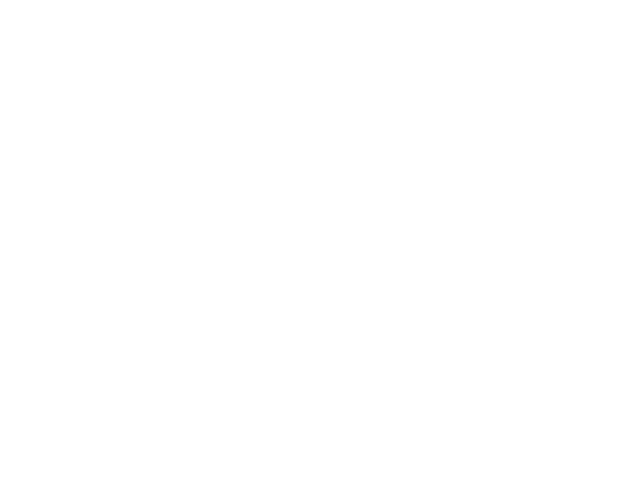

AttributeError: 'AxesSubplot' object has no attribute 'plt'

In [6]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot.()

def update(w = 1.0):
    line.set_ydata(np.sin(w * x))
    fig.canvas.draw()

interact(update);